# Don't Trust PyTorch to Initialize Your Variables
> why does good initialization matter in neural networks and what are vanishing gradients

- toc: true 
- badges: true
- comments: true
- author: Aditya Rana
- image: images/weightinit_meme.png
- categories: [theory]

This post is a summary of things I learnt while doing [Fast.ai's Deep Learning from Foundations](https://www.fast.ai/) and [Justin Johnsons's Computer Vision Course at UMichigan](https://web.eecs.umich.edu/~justincj/teaching/eecs442/schedule.html) which is the updated and latest version of CS231n.

## Situation

You want to solve a problem using deep learning. You have collected a dataset, decided on a neural network architecture, loss function, optimizer and some metrics you want to evaluate on. While training you notice your network isn't performing well, neither on train nor validation dataset. Looking for bugs while training neural networks is not a simple task, so we break down the whole training process into separate pipelines. Let's start by looking for bugs in our architecture and the way we initialize our weights.

## Problem: Why does good initialization matter?

As Neural Networks involve a lot of matrix multiplications, the mean and variance of activations can quickly shoot off to very high values or drop down to zero. This will cause the local gradients of our layers to become NaN or zero and hence prevent our network from learning anything . A common strategy to avoid this is to initialize the weights of your network using the latest techniques. For example if you’re using ReLU activation after a layer, you must initialize your weights with Kaiming He initialization and set the biases to zero.(This was introduced in the [2014 ImageNet winning paper from Microsoft](https://arxiv.org/abs/1502.01852)). This ensures the mean and standard deviation of activations of all layers stay close to 0 and 1 respectively.

<img src = "images/local_gradients_backprop.png" height="500" width="500">
<br>

<center>Upstream gradients are multiplied by local gradients to get the downstream gradients during backprop</center>

Let's compare the local gradient behavior of some common activation functions

<img src = "images/act_derivative.png" height="600" width="600">


Notice how the gradients in both sigmoid and tanh are non-zero only inside a certain range between [-5, 5]

Also notice that when using sigmoid, the local gradient achieves a maximum value of 0.25, thus every time gradient passes through a sigmoid layer, it gets diminished by at least 75%.

## Task

To ensure the gradients of our network do not explode or diminish to zero

1. The Mean of activations should be zero
2. The Variance of activations should stay same across layers. 

Intitalizing the network with the right weights can make the difference between converging in a few epochs versus not converging at all.

## Solution: Let's Compare Differrent Initialization Strategies

You must be wondering that surely it cannot be that bad. Let's consider a forward pass for a 6-layer neural network with each hidden layer the size of 4096 and tanh activation and let's plot the histogram for activations after each layer

### All Weights and Biases Set to Zero

<img src = "images/weightinit_meme.png" height="300" width="300">

<center><a href = "https://towardsdatascience.com/random-initialization-for-neural-networks-a-thing-of-the-past-bfcdd806bf9e">Image Source</a></center>

Do not ever do this! In such a case, all neurons of a layer would end up computing the same output, will receive the same gradients during backpropagation and undergo the same parameter updates. That means that all neurons of a layer will be learning the same features during training as there is no symmetry breaking. Also The problem with zero initialized layer is that since its output will be zero, it will halt the gradient flow at the next layer by making the local gradients of weights for the next layer zero. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.style.use('seaborn')

### Using Small Random Numbers from a Normal Distribution

Why Normal/Gaussian? Because it is characterized by its mean and variance, exactly the two things we want to control and compare

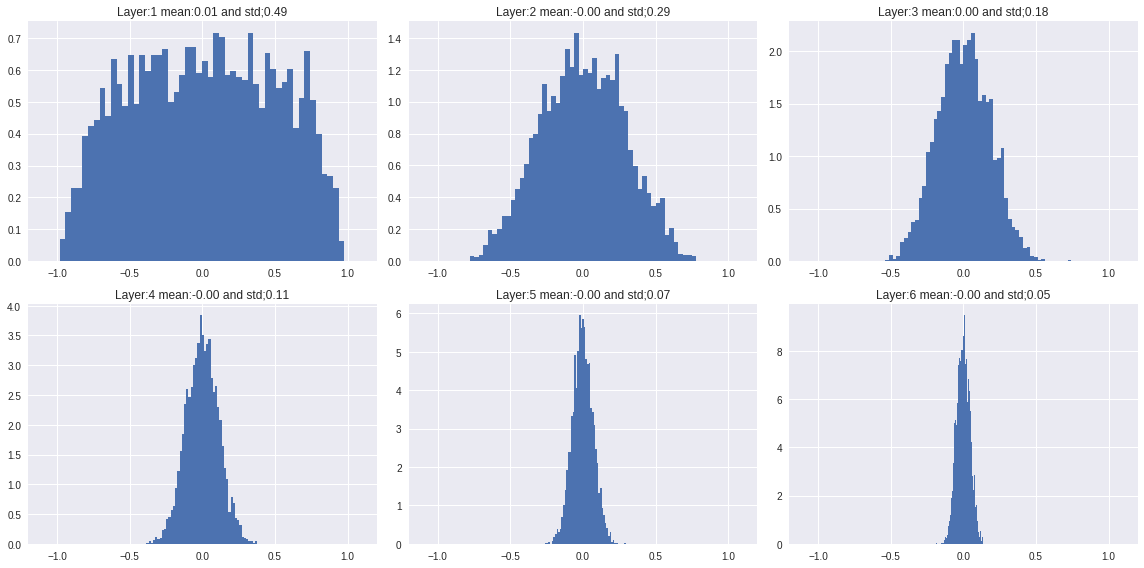

In [3]:
dims = [4096]*7
mean = []
std =  []
hist = []
x = np.random.randn(dims[0])
for Din, Dout in zip(dims[:-1],dims[1:]):
    #Focus here
    W = 0.01*np.random.randn(Din,Dout)
    x = np.tanh(x.dot(W))
    mean.append(x.mean())
    std.append(x.std())
    hist.append(x)
    
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
for i,ax,m,s in zip(np.arange(6),axes.flatten(),mean,std):
    ax.hist(hist[i],density = True,bins=50)
    ax.set_xlim(-1.2,1.2)
    ax.set_title(f'Layer:{i+1} mean:{m:.2f} and std;{s:.2f}')
plt.tight_layout()

### Why and when do gradients vanish?

As all activations tend to zero for deeper layers, the gradients are going to collapse to zero as well.Why?

<img src = "images/local_gradients_backprop.png" height="450" width="450">

Because whenever we compute local gradient on the weight, the local gradient of the weight is going to be equal to to the activation of the previous layer. So this  means for a deep network, if the activations before a layer collapse to zero, the local gradients on the weight collapse as well and the network will stop learning. That's why for gradients to stop vanishing or exploding it's important to prevent activations from vanishing or exploding respectively.

<img src = "images/lin_backprop.png" height="350" width="700">

### Backprop for a Linear Layer

If this part is unclear to you, you should revise backpropagation for a linear layer by having a look at [this post](https://web.eecs.umich.edu/~justincj/teaching/eecs442/notes/linear-backprop.html) by Justin Johnson. For extra resources you can also have a look at

1. http://cs231n.stanford.edu/handouts/linear-backprop.pdf
2. http://cs231n.stanford.edu/handouts/derivatives.pdf
3. https://web.stanford.edu/class/cs224n/readings/gradient-notes.pdf
4. https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1184/lectures/lecture5.pdf

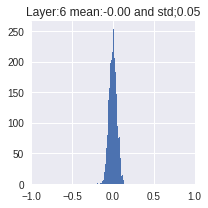

In [4]:
fig, ax = plt.subplots(figsize=(3,3))
ax.hist(hist[5],bins=50)
ax.set_title(f'Layer:{6} mean:{m:.2f} and std;{s:.2f}')
ax.set_xlim(-1,1)
plt.tight_layout()

As we can  see, most of the activations in the last layer are around zero.

The same activations as above super-imposed on each other. Plotting this just because it seems visually appealing to me

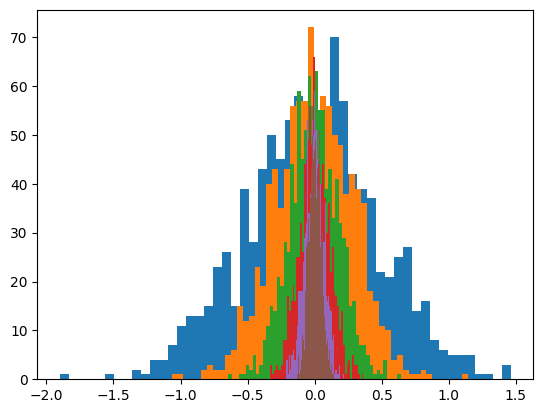

In [5]:
plt.style.use('default')
for m,s in zip(mean,std):
    a = np.random.normal(m,s,size=1000)
    plt.hist(a,bins=50)

In [6]:
plt.style.use('seaborn')

### Maybe larger weights will not get diminished

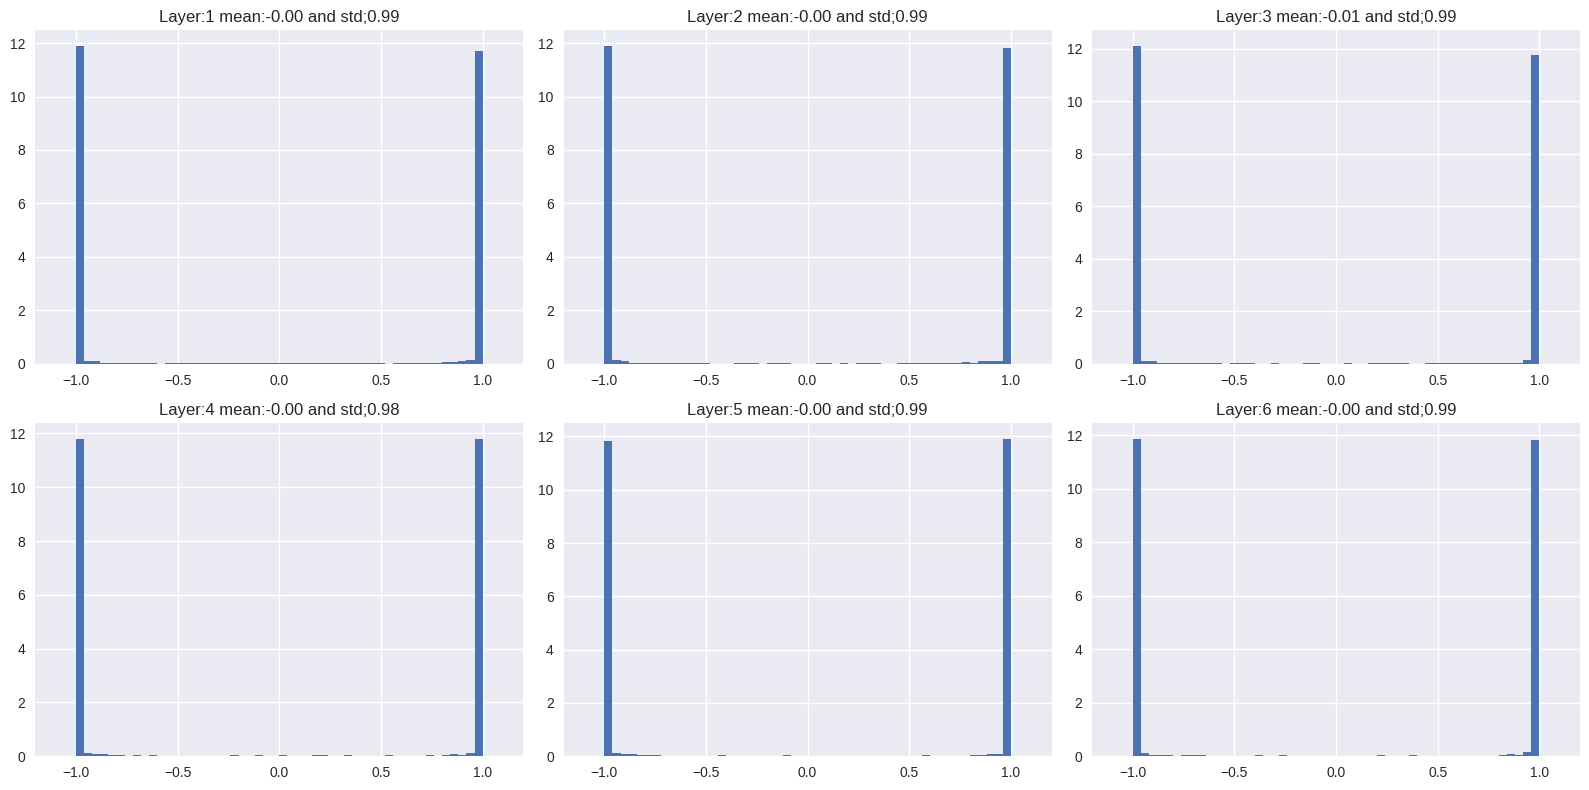

In [7]:
dims = [4096]*7
mean = []
std =  []
hist = []
x = np.random.randn(dims[0])
for Din, Dout in zip(dims[:-1],dims[1:]):
    W = 0.5*np.random.randn(Din,Dout)
    x = np.tanh(x.dot(W))
    mean.append(x.mean())
    std.append(x.std())
    hist.append(x)
    
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
for i,ax,m,s in zip(np.arange(6),axes.flatten(),mean,std):
    ax.hist(hist[i],density = True,bins=50)
    ax.set_xlim(-1.2,1.2)
    ax.set_title(f'Layer:{i+1} mean:{m:.2f} and std;{s:.2f}')
plt.tight_layout()

Wow, that was a disaster. All neurons are saturated and are outputting -1s and 1s where gradient is zero. Again, no learning

### Xavier : Magic Scaling Number  $$\sqrt{\frac{1}{Din}}$$

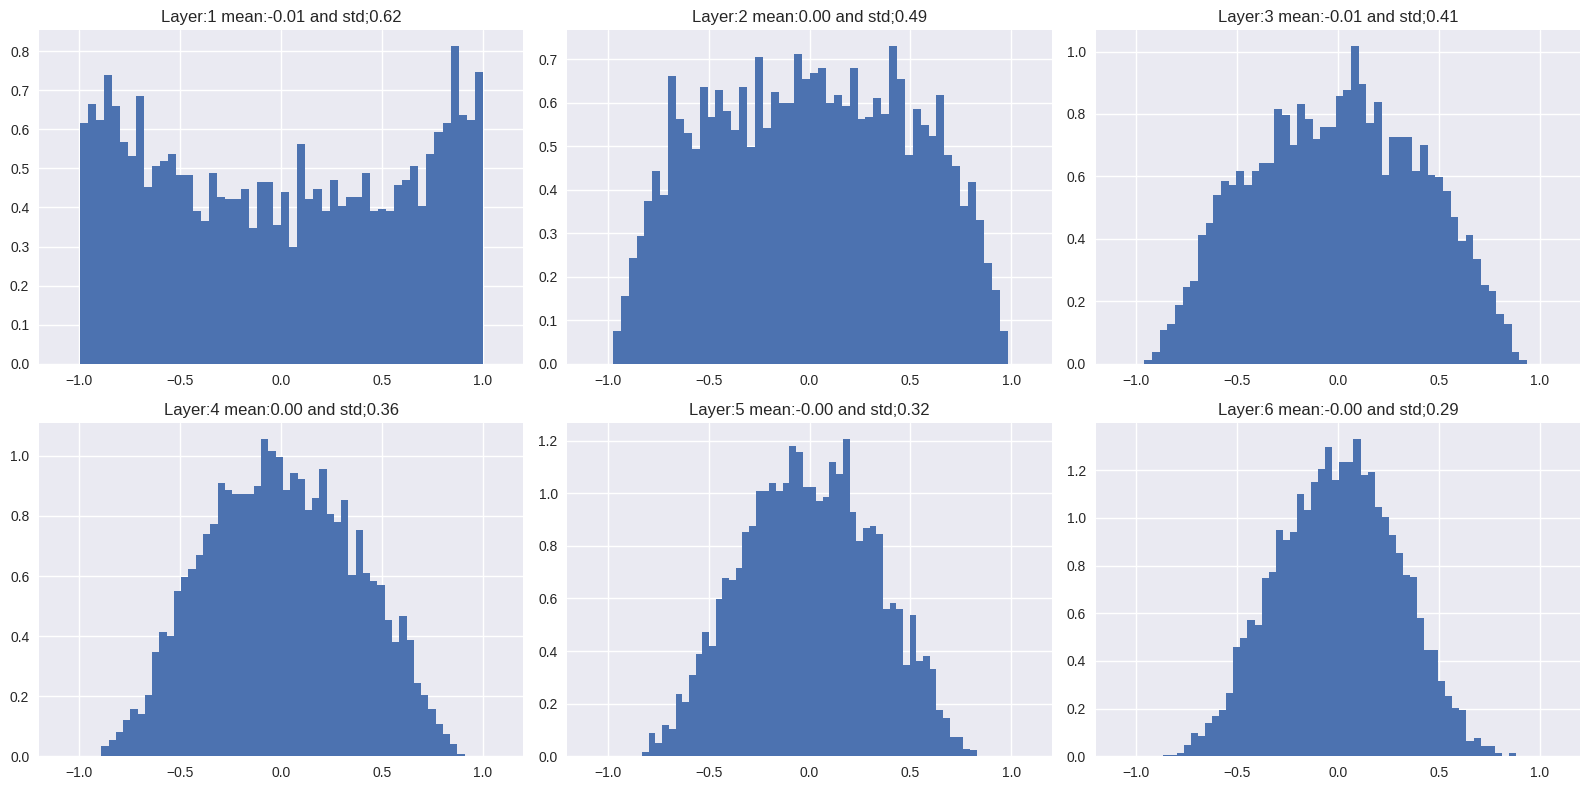

In [8]:
dims = [4096]*7
mean = []
std =  []
hist = []
x = np.random.randn(dims[0])
for Din, Dout in zip(dims[:-1],dims[1:]):
    W = np.random.randn(Din,Dout)/np.sqrt(Din)
    x = np.tanh(x.dot(W))
    mean.append(x.mean())
    std.append(x.std())
    hist.append(x)
    
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
for i,ax,m,s in zip(np.arange(6),axes.flatten(),mean,std):
    ax.hist(hist[i],density = True,bins=50)
    ax.set_xlim(-1.2,1.2)
    ax.set_title(f'Layer:{i+1} mean:{m:.2f} and std;{s:.2f}')
plt.tight_layout()

Hmmmmmmmmm, why did that work? This was proposed in [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a.html), the 2010 paper that introduced ‘Xavier initialization’ which we have just used.

But where does it come from? It's not that mysterious if you remember the definition of the matrix multiplication. When we do `y = x @ W`, the coefficients of `y` are defined by

$$y_{i} =  x_{1} w_{1} + x_{2} w_{2} + \cdots + x_{n} w_{n} = \sum_{j=1}^{Din} x_{j} w_{j} $$


Now at the very beginning, our `x` vector has a mean of roughly 0. and a standard deviation of roughly 1. (since we picked it that way).

$$ Var(y_{i}) = Var(x_{1} w_{1} + x_{2} w_{2} + \cdots + x_{n} w_{n}) $$

1. Assume x, w are iid $$ Var(y_{i}) = D_{in} * Var(x_{i} w_{i}) $$ 
2. Assume x, w independent $$ Var(y_{i}) = D_{in} * (E[x_{i}^2] E[w_{i}^2] - E[x_{i}]^2 E[w_{i}]^2) $$
3. Assume x, w are zero-mean $$ Var(y_{i}) = D_{in} * Var(x_{i}) * Var(w_{i}) $$

Hence for the variances to remain same between layers that is $$ Var(y_{i}) = Var(x_{i})$$ the condition is  $$ Var(w_i) = \frac{1}{Din} $$

That's it, the Xavier initialization.

### Kaiming Initialization, if using ReLU scale by $$\sqrt{\frac{2}{Din}}$$

Xavier initialization assumes the input to have zero mean, but things change when we use a ReLU which sets all negative values to zero. Let's see what happens if we continue using Xavier initialization with ReLU

(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)


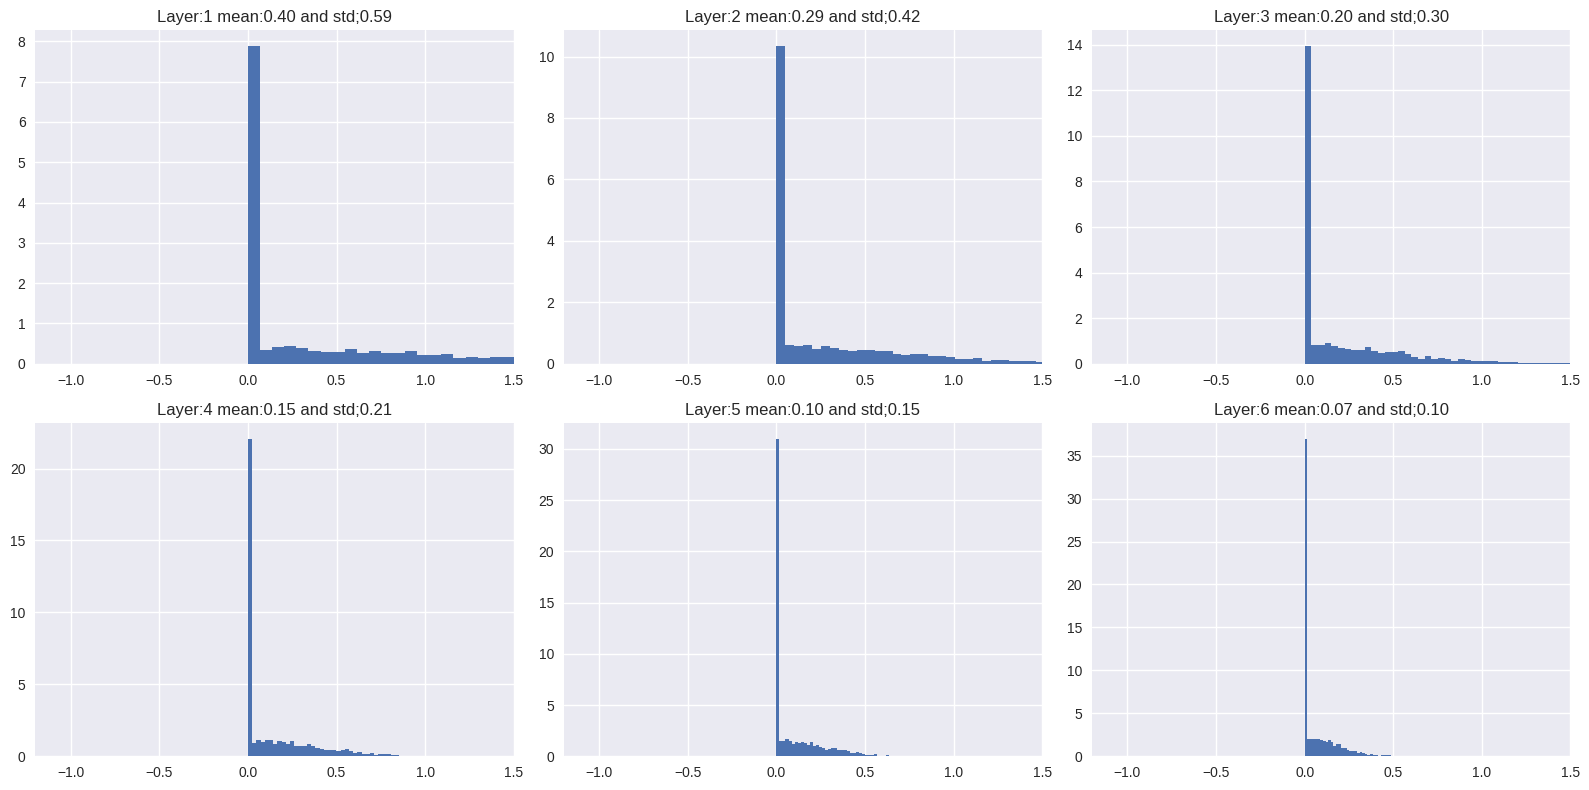

In [9]:
dims = [4096]*7
mean = []
std =  []
hist = []
x = np.random.randn(dims[0])
for Din, Dout in zip(dims[:-1],dims[1:]):
    W = np.random.randn(Din,Dout)/np.sqrt(Din)
    x = np.maximum(0, x.dot(W))
    print(x.shape)
    mean.append(x.mean())
    std.append(x.std())
    hist.append(x)
    
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
for i,ax,m,s in zip(np.arange(6),axes.flatten(),mean,std):
    ax.hist(hist[i],density = True,bins=50)
    ax.set_xlim(-1.2,1.5)
    ax.set_title(f'Layer:{i+1} mean:{m:.2f} and std;{s:.2f}')
plt.tight_layout()

Things aren't looking too good as most activations are again driven to zero on reaching the last layer. Let's try out Kaiming init now

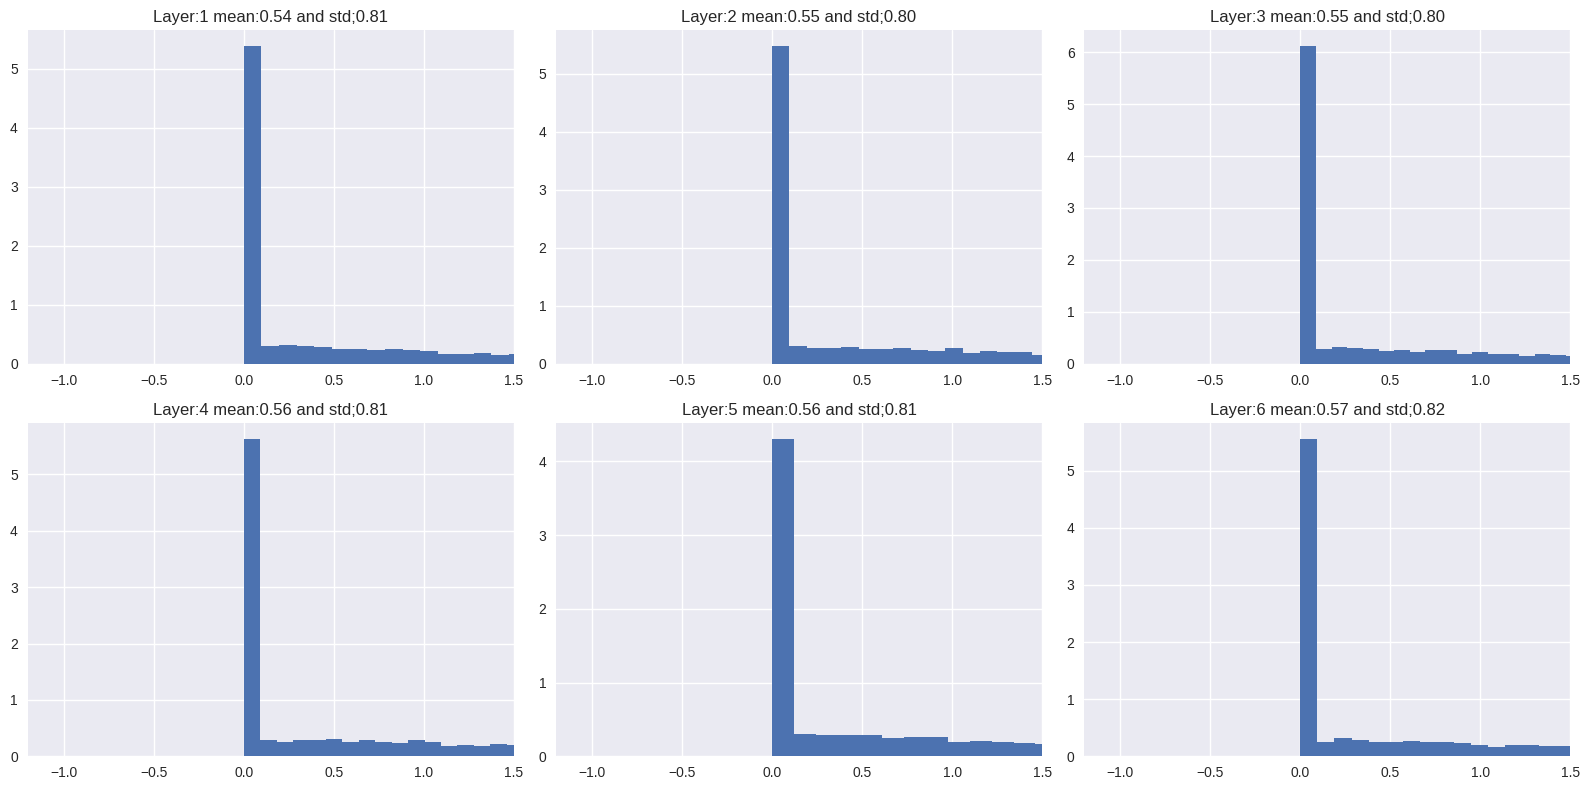

In [10]:
dims = [4096]*7
mean = []
std =  []
hist = []
x = np.random.randn(dims[0])
for Din, Dout in zip(dims[:-1],dims[1:]):
    W = np.random.randn(Din,Dout)/np.sqrt(Din/2)
    x = np.maximum(0, x.dot(W))
    mean.append(x.mean())
    std.append(x.std())
    hist.append(x)
    
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
for i,ax,m,s in zip(np.arange(6),axes.flatten(),mean,std):
    ax.hist(hist[i],density = True,bins=50)
    ax.set_xlim(-1.2,1.5)
    ax.set_title(f'Layer:{i+1} mean:{m:.2f} and std;{s:.2f}')
plt.tight_layout()

The activations look much better now

Here's a sample code if you get confused how to add multiple plots to the same figure. You can read more about this [here](https://akashpalrecha.me/tutorials/blog/2020/02/05/an-inquiry-into-matplotlibs-figures.html)

In [ ]:
#collapse-hide
xs = np.linspace(0, 2 * np.pi, 400)
ys = np.sin(xs ** 2)
xc = np.linspace(0, 2 * np.pi, 600)
yc = np.cos(xc ** 2)


fig, ax = plt.subplots(2, 2, figsize=(16, 8))
# `Fig` is short for Figure. `ax` is short for Axes.
ax[0, 0].plot(xs, ys)
ax[1, 1].plot(xs, ys)
ax[0, 1].plot(xc, yc)
ax[1, 0].plot(xc, yc)
fig.suptitle("Basic plotting using Matplotlib")
plt.show()

### How to calculate fan-in and fan-out in Xavier initialization for CNNs?

While reading the papers on initialization you'll come across these two terms 'fan-in' and 'fan-out' quite often. 

This part of my post is heavily inspired by [Matthew Kleinsmith's post on CNN Visualizations on Medium](https://medium.com/impactai/cnns-from-different-viewpoints-fab7f52d159c)

[![understanding fan_in and fan_out][1]][1]

fan-in is the same as Din that we have used in our code above. Similarly a Conv Layer can be seen as a Linear layer.

[![the image][2]][2] 
<center>The Image</center>

[![the filter][3]][3]  
<center>The Filter</center>

[![Output][4]][4] 
<center>Since the filter fits in the image four times, we have four results</center>


[![enter image description here][5]][5] 

<center>Here’s how we applied the filter to each section of the image to yield each result</center>

[![enter image description here][6]][6]

<center>The equation view</center>

[![enter image description here][7]][7]
<center>The compact equation view</center>

and now most importantly the neural network view where you can see each output is generated from 4 inputs and hence fan_in = 4.

[![The compact equation view][8]][8]

If the original image had been a 3-channel image, each output would be generated from 3*4 = 12 inputs and hence fan_in would be 12. Hence,

````
receptive_field_size = kernel_height * kernel_width
fan_in = num_input_feature_maps * receptive_field_size
fan_out = num_output_feature_maps * receptive_field_size
````

I would also encourage you to play around with the PyTorch functions for calculating fan_in and fan_out [here.](https://pytorch.org/docs/stable/_modules/torch/nn/init.html). Somewhat like this, referring to the example above


  [1]: https://i.stack.imgur.com/cR1l6.png
  [2]: https://i.stack.imgur.com/dntEl.png
  [3]: https://i.stack.imgur.com/BpDlB.png
  [4]: https://i.stack.imgur.com/BitZP.png
  [5]: https://i.stack.imgur.com/tTDWy.png
  [6]: https://i.stack.imgur.com/NsvS5.png
  [7]: https://i.stack.imgur.com/Fkeeb.png
  [8]: https://i.stack.imgur.com/UfEQt.png

In [ ]:
import torch
conv = torch.nn.Conv2d(in_channels=1,out_channels=1,kernel_size=2)
print(f'Conv shape: {conv.weight.shape}')

In [ ]:
#returns fan_in and fan_out value for a layer
torch.nn.init._calculate_fan_in_and_fan_out(conv.weight)

In [ ]:
print(f'number of elements: {conv.weight.numel()}')
print(f'mean: {conv.weight.mean()} and std: {conv.weight.std()} ')

In [ ]:
torch.nn.init.kaiming_normal_(conv.weight,nonlinearity='relu');
print(f'mean: {conv.weight.mean()} and std: {conv.weight.std()} ')

Don't worry seeing a high mean above, it's because our sample size is small as our filter only has 4 elements. In a normal convolution filter, this wouldn't be the case

## Play around with your own network

deeplearning.ai has built an amazing interactive tool to test out all the things we have discussed above. Go check it out at https://www.deeplearning.ai/ai-notes/initialization/

## Okay, now why can't we trust PyTorch to initialize our weights for us by default?

I've recently discovered that PyTorch does not use modern/recommended weight initialization techniques by default when creating Conv/Linear Layers. They've been doing it using the old strategies so as to maintain backward compatibility in their code. I know it sounds strange, weird and very stupid but unfortunately it's true. As of 26th August 2020, [this issue](https://github.com/pytorch/pytorch/issues/18182) is still open on Github

### Bug

In [ ]:
torch.nn.modules.conv._ConvNd.reset_parameters??

````python
Signature: torch.nn.modules.conv._ConvNd.reset_parameters(self)
Docstring: <no docstring>
Source:   
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)
File:      ~/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/nn/modules/conv.py
Type:      function
````

The above bug exists because PyTorch was adapted from Torch library, and authors found sqrt(5) to work well, but there's no justification or intuition behind this. Surprisingly, Tensorflow also uses the Xavier uniform initialization for Conv2d by default as well, which is again suboptimal when working with ReLU.

However, when PyTorch provides pretrained resnet and other architecture models, they cover up for this by explicitly initializing  layers in the code with kaiming normal. You can see an example [here](https://github.com/pytorch/vision/blob/a75fdd4180683f7953d97ebbcc92d24682690f96/torchvision/models/resnet.py#L160). So this means

1. If you're importing a network from torchvision, it was initialized properly and there is nothing to worry about but
2. If you cut some of its layers and replace it with your own layers, you need to initialize them again as per recommended methods which is kaiming normal if you're working with ReLU function.
3. If you're writing your own layers which is what happens 99% of the case, initialize them explicitly

### Solution

The most foolproof thing to do is to explicitly initialize the weights of your network using [torch.nn.init](https://pytorch.org/docs/stable/nn.init.html)

````python
def conv(ni, nf, ks=3, stride=1, padding=1, **kwargs):
    _conv = nn.Conv2d(ni, nf, kernel_size=ks,stride=stride,padding=padding, **kwargs)
    nn.init.kaiming_normal_(_conv.weight)
    return _conv
````

### Weight Initialization: Residual Networks


For Residual networks, the following code is used which initializes all Conv layers  with Kaiming intialization, and BatchNorm layers with unit $\gamma$ and zero $\beta$ so that in the intial forward passes they act as identity function and do not affect the means and variance of activations. You can follow along the full code [here](https://github.com/pytorch/vision/blob/a75fdd4180683f7953d97ebbcc92d24682690f96/torchvision/models/resnet.py#L160)

````python
for m in self.modules():
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

````
Also, the second BatchNorm layer used in BasicBlock and Bottleneck of ResNet architecture is initialized to zero, for the reason of exploding activations explained below

````python
        
# Zero-initialize the last BN in each residual branch,
# so that the residual branch starts with zeros, and each residual block behaves like an identity.
# This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
if zero_init_residual:
    for m in self.modules():
        if isinstance(m, Bottleneck):
            nn.init.constant_(m.bn3.weight, 0)
        elif isinstance(m, BasicBlock):
            nn.init.constant_(m.bn2.weight, 0)
````

You can also do it recursively if you want

````python
def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)
````

## Fixup Init

Training deep neural networks efficiently was a big problem in the deep learning community for a long time, that is until the [BatchNorm](https://arxiv.org/abs/1502.03167) paper came along. BatchNorm helps in stabilizing the layer activations and allows much deeper models to train without the problem of vanishing gradients.

But recently, a new paper called Fixup has shown that it's possible to train a  network as deep as 100 layers without using BatchNorm, and instead using an appropriate initialization scheme for different types of layers.

<img src = "images/residual_init.png" height="200" width="200">

Problem : If we initialize with Kaiming: then $Var(F(x)) = Var(x)$.
But now $Var(F(x) + x)$ will be greater than $Var(x)$ as variance grows with each block!

Solution: Initialize first conv with Kaiming, initialize
second conv to zero. Then $Var(x + F(x)) = Var(x)$

### Intuition

I had a hard time getting my head around why initializing a layer with all zeros was not seen as a red flag here. That was exactly the first thing I had asked you to be cautious of. So what is going on here? I asked these questions on the [fast.ai forum](https://forums.fast.ai/t/fixup-init-resnet-without-normalization/37107/11) and [Twitter](https://twitter.com/adityassrana/status/1301197369220849664) and when I didn't get any replies :( I realized sometimes you need to answer your questions.

<img src = "images/lin_backprop.png" height="350" width="700">

### Initial Confusion that I had

If last conv layer in a residual branch is initialized to zero, then there would be no symmetry breaking amongst different filters. All the filters learned in that layer would be identical, as each filter will
1. receive the same upstream gradient 
2. will go over the same input/activation from previous layer and hence have the same local gradient

<img src = "images/local_gradients_backprop.png" height="450" width="450">

### Where was I wrong?

This [blog post](https://medium.com/@pavisj/convolutions-and-backpropagations-46026a8f5d2c) really helped me gain clarity on backpropagation in CNNs and was super helpful in understanding Fixup init. Another cool thing I learnt is that backpropagation in a CNN is also a convolution operation. Go through the post to go through the math

1. I was wrong to assume that each filter will receive the same upstream gradient. So in fact, each filter will receive different upstream gradient.

Each filter of a kernel is like an independent linear linear layer that outputs one channel of activations by going over the input. A filter will only receive upstream gradients from that single channel activations that it outputs.

All the individual activations outputted from each filter are combined to get the output size equal to the number of filters used in the kernel.

### So can we use zero initialization in general?

No, it only works here because of the residual connection that exists right after the zero initialized Conv layer. The problem with zero initialized layer is that since its output will be zero, it will halt the gradient flow at the next layer by making the local gradients of weights for the next layer zero. 

But in this case, the output will not be zero as a residual connnection exists and the activations from some previous layer is being added to the zero output before being processed by the next layer.

## Papers Discussed

1. [Understanding the difficulty of training deep feedforward neural networks by Glorot and Bengio](http://proceedings.mlr.press/v9/glorot10a.html)
2. [Delving Deep into Rectifiers by He et al.](https://arxiv.org/abs/1502.01852)
3. [Batch Normalization by Sergey Ioffe and Christian Szegedy](https://arxiv.org/abs/1502.03167)
4. [Fixup Initialization: Residual Learning Without Normalization by Zhang et al.](https://arxiv.org/abs/1901.09321)

## Extra Readings

If you want to get deep (pun intended) into playing around with these concepts I would highly recommend you to watch fast.ai's Deep Learning from the Foundations, spending most of your time reimplementing the notebooks by yourself.

1. [3Blue1Brown Neural Networks Playlist:](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi) If you're new to all this and confused about what networks have to do with linear algebra
2. [Slides by Justin Johnson and CS231n](https://web.eecs.umich.edu/~justincj/slides/eecs498/498_FA2019_lecture10.pdf) The slides that inspired the above experiments
3. [Yes you should understand backprop by Andrej Karpathy](https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b)
4. https://pouannes.github.io/blog/initialization/ to read more theoretical proofs of Xavier and Kaiming init.
5. https://jimypbr.github.io/2020/02/fast-ai-lesson-8-notes-backprop-from-the-foundations
6.  https://medium.com/comet-ml/selecting-the-right-weight-initialization-for-your-deep-neural-network-780e20671b22